In [1]:
import torch
import gc
import torchvision.models as models
import torch.nn as nn

import dataloader
import trainer
import evaluator
import visualizer

## Main Functions

Auto-reload files imported to the notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


In [4]:
TILE_HEIGHT, TILE_WIDTH = 80, 80

For torch dataloader to use num_workers > 0, it relies on python multiprocessing, which in windows have deadlock issues, unless the instantiation is in a .py module and the code that invokes it is wrapped inside a \__main__ section.
https://github.com/pytorch/pytorch/issues/51344

In [5]:
if __name__ == '__main__':
    loader_train, loader_val, loader_test = dataloader.main(TILE_HEIGHT, TILE_WIDTH, batch_size=10, num_workers=3)

In [6]:
# Free cuda memory
# Reference: https://discuss.pytorch.org/t/how-to-debug-causes-of-gpu-memory-leaks/6741/13
def freemem():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) and torch.is_tensor(obj.data):
            del obj
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

## Mobilenet

Here we import the mobilenet model with pretrained weights. This gives us some good starting weights so that we don't have to train the model from scratch.

In [7]:
mobilenet = models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/ethanruoff/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100.0%


From there, we replace the last layer to work with the tiles format rather than mobilenet's standard classification. Lastly, we freeze all of the layers except for the newly added layer so that it can be trained individually

In [8]:
mobilenet.classifier[-1] = nn.Linear(1280, TILE_HEIGHT*TILE_WIDTH)
print(mobilenet.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=6400, bias=True)
)


##### NOTE: If you want to load the saved model then skip then section and run from the Visualize Model section

In [ ]:
for param in mobilenet.parameters():
    param.require_grad = False
mobilenet.classifier[-1].requires_grad_(True)

Now let's train the model!

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
mobilenet = mobilenet.to(device)
trainer.train(mobilenet, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

Unfreeze the layers and train with the fully unfrozen model

In [18]:
for param in mobilenet.parameters():
    param.require_grad = True
trainer.train(mobilenet, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

torch.save(mobilenet.state_dict(), 'saved_models/mobilenet.model')

Training epoch 1 batch 150/300, train loss = 0.022398, train acc = 0.991984, recall = 0.268441, precision = 0.680235
validation metrics at epoch 1 batch 150: val loss = 0.026818, val acc = 0.991151, val recall = 0.198995, val precision = 0.587663
Training epoch 1 batch 300/300, train loss = 0.022447, train acc = 0.991871, recall = 0.272744, precision = 0.669582
validation metrics at epoch 1 batch 300: val loss = 0.027160, val acc = 0.991023, val recall = 0.237719, val precision = 0.555245
current_patience = 9
Epoch 1/100 train loss = 0.022447, train acc = 0.991871, val loss = 0.027160, val acc = 0.991023
Training epoch 2 batch 150/300, train loss = 0.021685, train acc = 0.992127, recall = 0.275347, precision = 0.682170
validation metrics at epoch 2 batch 150: val loss = 0.027139, val acc = 0.990469, val recall = 0.293604, val precision = 0.489054
current_patience = 8
Training epoch 2 batch 300/300, train loss = 0.022121, train acc = 0.992022, recall = 0.283036, precision = 0.684643
val

([0.02681813485920429,
  0.027160032615065575,
  0.02713856615126133,
  0.026610926911234855,
  0.026533921994268895,
  0.026243202947080137,
  0.026591709330677987,
  0.026186857335269452,
  0.027262344174087048,
  0.02699666704982519,
  0.027012421227991582,
  0.026575788371264935,
  0.027787906117737293,
  0.027210327237844466,
  0.026790320053696633,
  0.02694450818002224,
  0.027317871786653996,
  0.026173584945499897,
  0.026822077631950377,
  0.026936701014637947,
  0.027331936284899713,
  0.026965696178376675,
  0.026821876652538778,
  0.026457601748406886,
  0.026762000881135464,
  0.026815281249582767,
  0.027647956758737564,
  0.027214638888835907],
 [0.9911505949497222,
  0.9910232031345367,
  0.9904693496227265,
  0.9911358773708343,
  0.9909319365024567,
  0.9912172901630402,
  0.9909661734104156,
  0.9911846220493317,
  0.9907194304466248,
  0.9912977480888366,
  0.9911615753173828,
  0.9908379542827607,
  0.9911326575279236,
  0.9911859083175659,
  0.991059398651123,
  

## Model Visualizations

Load the model if you dont want to train it

In [10]:
mobilenet.load_state_dict(torch.load('saved_models/mobilenet.model', map_location=torch.device(device)))

<All keys matched successfully>

torch.Size([10, 3, 48, 80, 80]) torch.Size([10, 3, 48, 80, 80])
Accuracy = 98.74922037124634%
Precision = 3.0976677313447%
Recall = 1.335952803492546%


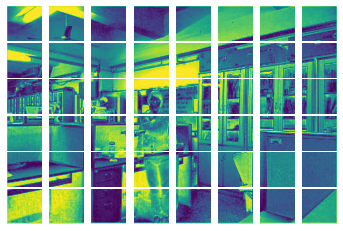

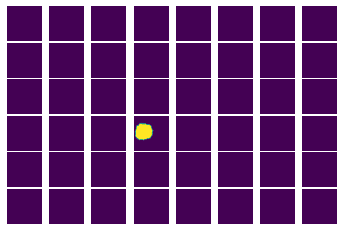

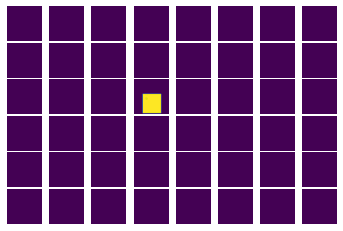

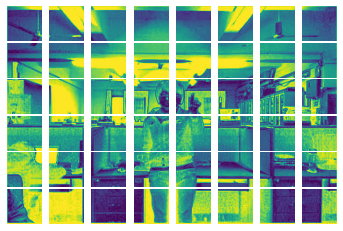

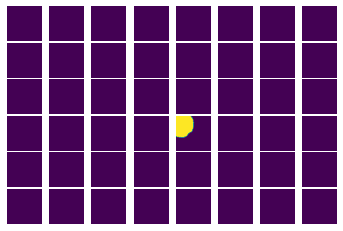

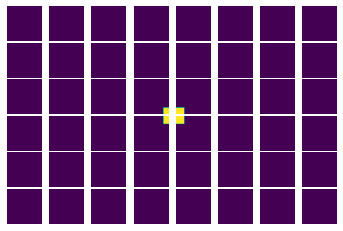

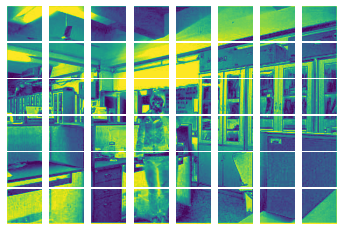

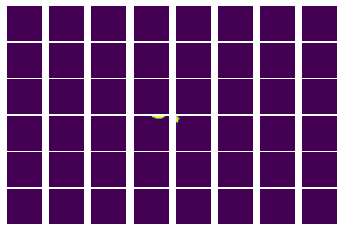

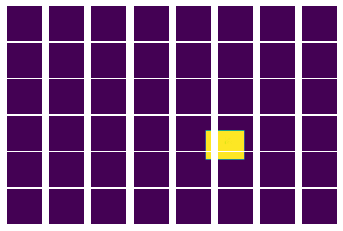

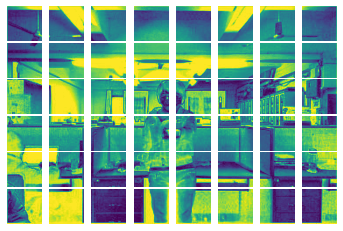

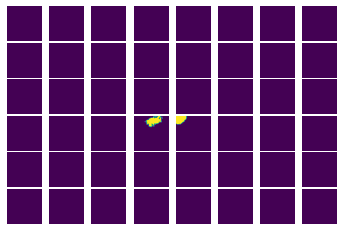

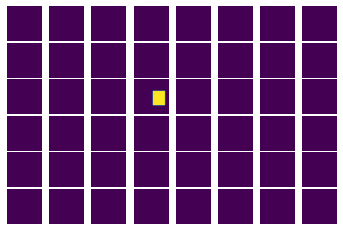

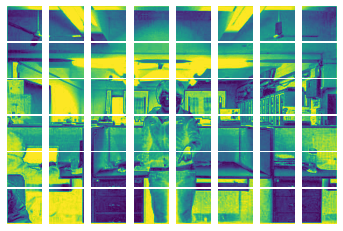

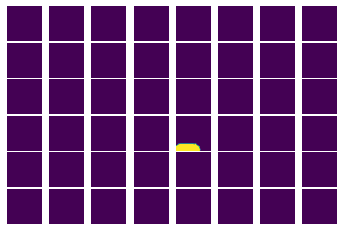

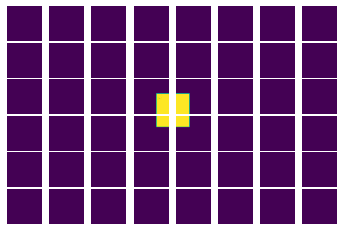

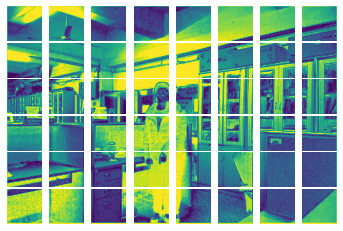

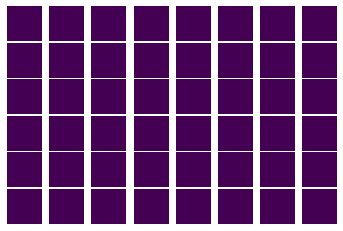

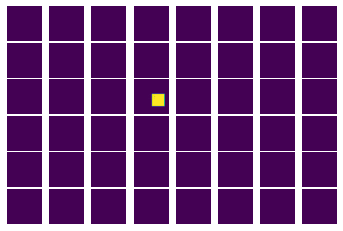

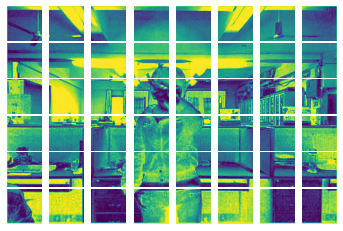

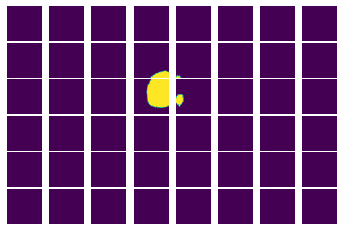

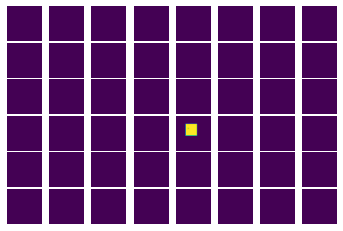

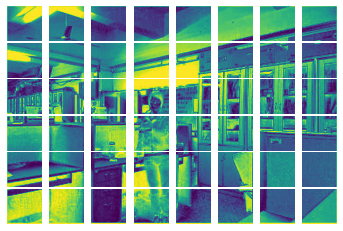

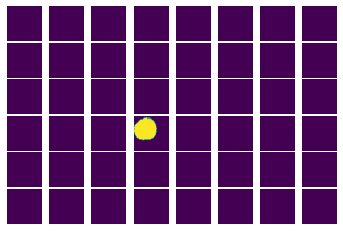

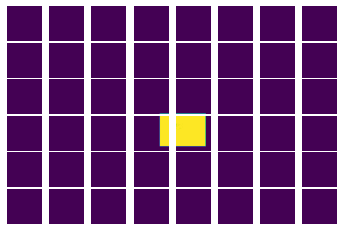

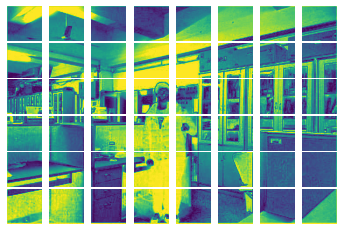

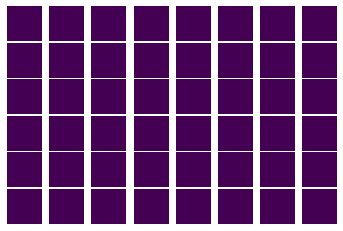

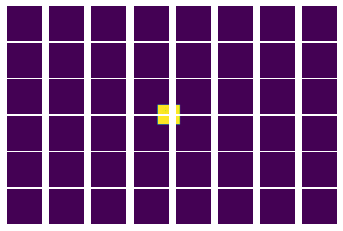

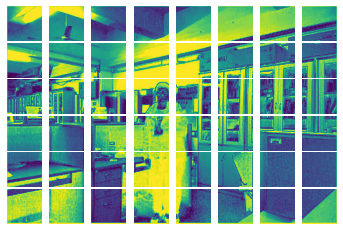

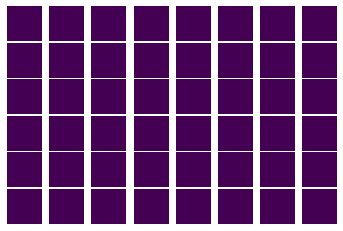

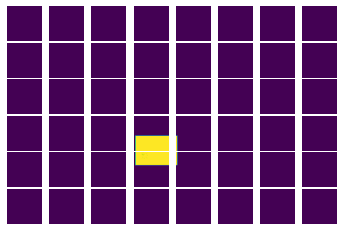

In [14]:
visualizer.visualize_model_output(loader_test, mobilenet, 10, TILE_HEIGHT=80, TILE_WIDTH=80, device=device)